In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [5]:
hgg = ak.from_parquet('/project01/ndcms/cmoore24/skims/skimmed_jets/mc/nolepton/tagged/hgg.parquet')
qcd = ak.from_parquet('/project01/ndcms/cmoore24/skims/skimmed_jets/mc/nolepton/tagged/qcd_470to600.parquet')

In [6]:
hgg = hgg.goodjets

In [7]:
hgg = hgg[(hgg.btag_count==0)]

In [8]:
qcd = qcd.goodjets

In [9]:
qcd = qcd[(qcd.btag_count==0)]

In [10]:
hgg = hgg[hgg.msoftdrop <= 170]
hgg = hgg[hgg.msoftdrop >= 80]
hgg = hgg[hgg.pt <= 600]
hgg = hgg[hgg.pt >= 450]

In [11]:
qcd = qcd[qcd.msoftdrop <= 170]
qcd = qcd[qcd.msoftdrop >= 80]
qcd = qcd[qcd.pt <= 600]
qcd = qcd[qcd.pt >= 450]

In [12]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return sample

In [13]:
hgg = nan_remover(hgg)

In [14]:
qcd = nan_remover(qcd)

In [15]:
path = '/scratch365/cmoore24/training/hgg/batch/outputs_pecf/256nodes_3layers_30ecfs_32batch'

In [16]:
with open(f'{path}/selected_vars.txt', 'r') as f:
    ecf_list = f.readlines()
ecf_list = [item.strip() for item in ecf_list]

# with open(f'{path}/all_features.pkl', 'rb') as f:
#     ecf_list = pickle.load(f)

In [17]:
len(ecf_list)

30

In [18]:
model = f'{path}/traced_model.pt'

In [19]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [20]:
def imapper(array, ratio_list):
    imap = {}
    imap['vars'] = {}
    for i in ratio_list:
        try:
            imap['vars'][i] = array.ratios[i]
        except:
            imap['vars'][i] = array[i]
    return imap

In [21]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler, imap):
        #fatjets = events

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [22]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [23]:
hgg_imap = imapper(hgg, ecf_list)
hgg_scores = tagger(hgg, scaler, hgg_imap)[:,0]

In [24]:
qcd_imap = imapper(qcd, ecf_list)
qcd_scores = tagger(qcd, scaler, qcd_imap)[:,0]

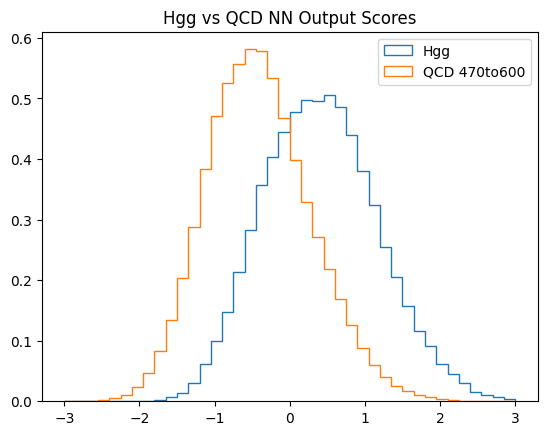

In [25]:
pltrange = (-3, 3)
plt.hist(hgg_scores, bins=40, histtype='step', label='Hgg', density=True, range=pltrange)
plt.hist(qcd_scores, bins=40, histtype='step', label='QCD 470to600', density=True, range=pltrange)
plt.title(f'Hgg vs QCD NN Output Scores')
plt.legend()
plt.show()

In [26]:
mask = ~np.isnan(qcd_scores)
qcd_scores = qcd_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
qcd_train = qcd[mask]

In [27]:
mask = ~np.isnan(hgg_scores)
hgg_scores = hgg_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
hgg_train = hgg[mask]

In [28]:
bkg_zeros = ak.zeros_like(qcd_scores)
sig_ones = ak.ones_like(hgg_scores)
combined = ak.concatenate([qcd_scores,hgg_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [29]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [30]:
hrange=(np.floor(ak.min(hgg_scores)), np.ceil(ak.max(hgg_scores)))

In [31]:
hgg_hist = np.histogram(hgg_scores, bins=20,
                range=hrange
                )
qcd_hist = np.histogram(qcd_scores, bins=20, 
                 range=hrange
                )

In [32]:
sig_sums = []
for i in range(len(hgg_hist[0])+1):
    sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))

bkg_sums = []
for i in range(len(qcd_hist[0])+1):
    bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

In [33]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [34]:
wp_ratios = {}
for i in range(len(hgg_hist[1])):
    wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

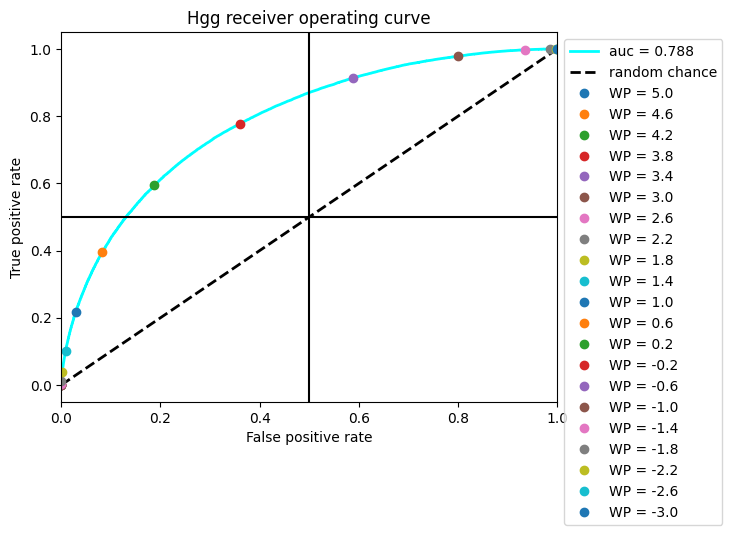

In [35]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.1f}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [36]:
i

'-3.0'

In [37]:
def get_percentile_cut(data, target_percentile=0.25):
    data = np.array(data)
    cut_value = np.percentile(data, (1 - target_percentile) * 100)
    return cut_value

In [38]:
cut = get_percentile_cut(hgg_scores)
cut
#cut = 0.899

0.9138229489326477

In [39]:
mask = ~((qcd_scores >= cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

In [40]:
mask = ((qcd_scores >= cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

In [41]:
with open('/afs/crc.nd.edu/user/c/cmoore24/Public/hgg/ml/ml_processor_work/jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open('/afs/crc.nd.edu/user/c/cmoore24/Public/hgg/ml/ml_processor_work/jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [42]:
scale = ((44.99*(xsecs['qcd']['qcd_470to600']*1000))/totals['qcd']['470to600'])
qcd_pass_hist.view(flow=True)[:] *= scale
qcd_fail_hist.view(flow=True)[:] *= scale

In [43]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist

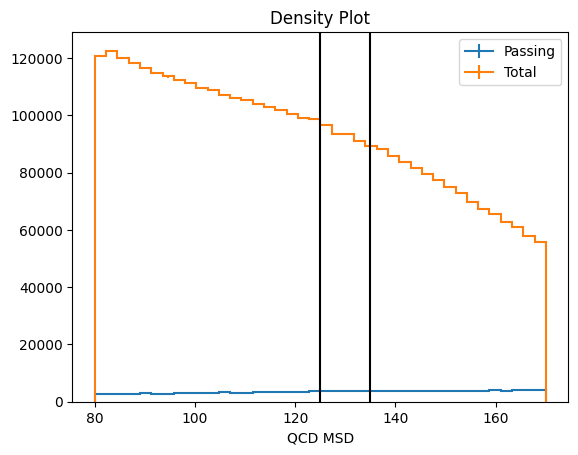

In [46]:
qcd_pass_hist.plot1d(density=False, label='Passing')
total_qcd_hist.plot1d(density=False, label='Total')
plt.title('Density Plot')
plt.axvline(135, color='black')
plt.axvline(125, color='black')
plt.legend()
plt.show()

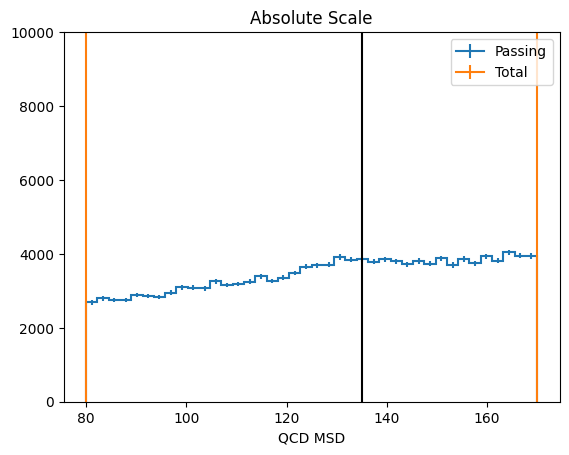

In [48]:
qcd_pass_hist.plot1d(density=False, label='Passing')
total_qcd_hist.plot1d(density=False, label='Total')
plt.title('Absolute Scale')
plt.axvline(135, color='black')
plt.ylim(0, 10000)
plt.legend()
plt.show()

In [49]:
mask = ~((hgg_scores >= cut))
hgg_cut_msd = hgg_train.msoftdrop[mask]
hgg_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_fail_hist.fill(msd=hgg_cut_msd);

In [50]:
mask = ((hgg_scores >= cut))
hgg_cut_msd = hgg_train.msoftdrop[mask]
hgg_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_pass_hist.fill(msd=hgg_cut_msd);

In [51]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hgg_fail_hist.view(flow=True)[:] *= scaleHgg
hgg_pass_hist.view(flow=True)[:] *= scaleHgg

In [52]:
total_hgg_hist = hgg_pass_hist + hgg_fail_hist

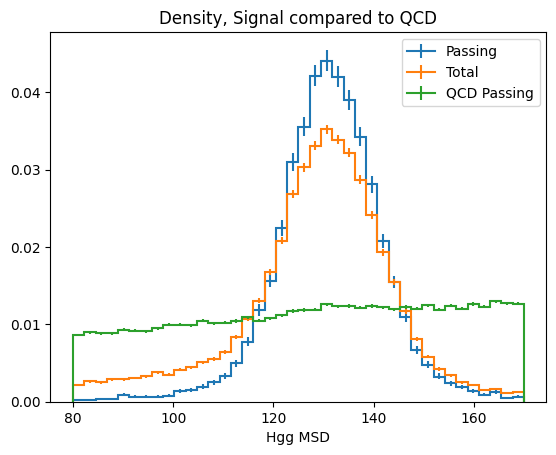

In [53]:
hgg_pass_hist.plot1d(density=True, label='Passing')
total_hgg_hist.plot1d(density=True, label='Total')
qcd_pass_hist.plot1d(density=True, label='QCD Passing')
plt.title('Density, Signal compared to QCD')
plt.legend()
plt.show()

In [54]:
sum(hgg_pass_hist.values()), sum(total_hgg_hist.values())

(7.745252665524567, 30.97883970461002)

In [55]:
ecf_list

['ecf_tagger',
 'pt',
 'n3b1',
 'tau1',
 'color_ring',
 'particleNet_TvsQCD',
 'tau4',
 'eta',
 'deepTagMD_WvsQCD',
 'mass',
 'particleNet_H4qvsQCD',
 'particleNetMD_Xqq',
 'tau3',
 'phi',
 'deepTag_TvsQCD',
 'btagDDCvLV2',
 'n2b1',
 'particleNetMD_QCD',
 'tau2',
 'msoftdrop',
 'deepTag_H',
 'btagDDCvBV2',
 'deepTag_WvsQCD',
 'deepTagMD_TvsQCD',
 'particleNet_ZvsQCD',
 'particleNetMD_Xcc',
 'Proba',
 'deepTagMD_H4qvsQCD',
 'particleNet_HbbvsQCD',
 'DDX_trackSip2dSigAboveCharm']